In [5]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import os
from matplotlib import pyplot as plt

In [60]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.style.use('ggplot')

In [6]:
# 获取当前路径下的文件名清单
path = './data/Data_Action'
file_list = os.listdir(path)
print(file_list)

['Data_Action_201602.csv', 'Data_Action_201603.csv', 'Data_Action_201604.csv']


In [7]:
# 获取文件名的年-月
file_year_month = os.path.splitext(file_list[0])[0].split('_')[-1]
file_year_month

'201602'

In [8]:
# 获取当前路径下的csv文件名
file_path1 = os.path.join(path,file_list[0])
file_path1

'./data/Data_Action\\Data_Action_201602.csv'

In [9]:
# 读取csv数据
df_201402 = pd.read_csv(file_path1)
df_201402.shape
# df1.head()

(11485424, 7)

In [13]:
# 封装函数：读取、合并文件数据
def concat_csv(path,size=10000):
    '''
    path ： 文件路径
    size ： 数据行数
    '''
    df_actions = pd.DataFrame()
    
    file_list = os.listdir(path)
    
    for name_str in file_list:
        
        # 读取数据
        file_path = os.path.join(path,name_str)
        df = pd.read_csv(file_path, header=0, iterator=True)  
        
        # 使用迭代器的方式取出数据
        chunks = []
        loop = True
        while loop:
            try:
                chunk = df.get_chunk(size)[["user_id", "sku_id", "type", "time",'cate']]
                chunks.append(chunk)
            except StopIteration:
                loop = False
                print("Iteration is stopped")
        df_action = pd.concat(chunks,ignore_index=True)  
    # 合并多表数据                     
        df_actions = df_actions.append(df_action,ignore_index=True)
        
    return df_actions
    
path = './data/Data_Action'
df_actions = concat_csv(path)
df_actions

Iteration is stopped
Iteration is stopped
Iteration is stopped


,user_id,sku_id,type,time,cate
0,266079.0,138778,1,2016-01-31 23:59:02,8
1,266079.0,138778,6,2016-01-31 23:59:03,8
2,200719.0,61226,1,2016-01-31 23:59:07,8
3,200719.0,61226,6,2016-01-31 23:59:08,8
4,263587.0,72348,1,2016-01-31 23:59:08,5
...,...,...,...,...,...
50601731,236482.0,7199,6,2016-04-15 23:59:57,4
50601732,236482.0,7199,6,2016-04-15 23:59:57,4
50601733,228530.0,85780,6,2016-04-15 23:59:58,5
50601734,228530.0,85780,6,2016-04-15 23:59:58,5


### 备注：用户行为表
- sku_id：商品编号
- type：行为类型 （1-浏览商品详情页，2-加入购物车，3-购物车删除，4-下单，5-关注，7-点击）
- time：行为时间
- cate：品类ID

In [32]:
# 清洗数据
# 1）去重
df_actions.drop_duplicates(inplace=True)

# 2）查看缺失率
df_actions.apply(lambda x:x.isnull().sum()/len(x))

user_id    0.0
sku_id     0.0
type       0.0
time       0.0
cate       0.0
dtype: float64

## 1.标记高潜用户
高潜用户具有的特征：
- 必须有购买行为
- 对一个商品购买和其他交互行为（浏览、点击、收藏等）时间差应该多余一天

In [14]:
# 提取有购买行为的数据
df_ac_order = df_actions[df_actions['type']==4]
df_ac_order

,user_id,sku_id,type,time,cate
351,269365.0,166345,4,2016-02-01 00:01:00,9
649,235443.0,36692,4,2016-02-01 00:02:00,4
980,247689.0,9112,4,2016-02-01 00:03:00,5
1719,273959.0,102034,4,2016-02-01 00:05:00,5
2153,226791.0,163550,4,2016-02-01 00:06:00,4
...,...,...,...,...,...
50597077,242683.0,161265,4,2016-04-15 23:53:00,8
50597721,215804.0,157750,4,2016-04-15 23:54:00,5
50599086,275840.0,18412,4,2016-04-15 23:56:00,8
50600374,291147.0,70491,4,2016-04-15 23:58:00,6


In [30]:
# 下单商品中各品类占比统计
cate_count = df_ac_order.groupby('cate').count()
cate_count['rate'] = [i/df_ac_order.shape[0] for i in cate_count['user_id'].tolist()] 
cate_count

,user_id,sku_id,type,time,rate
cate,,,,,
4,9326,9326,9326,9326,0.193277
5,8138,8138,8138,8138,0.168656
6,6982,6982,6982,6982,0.144699
7,6214,6214,6214,6214,0.128782
8,13281,13281,13281,13281,0.275242
9,4104,4104,4104,4104,0.085053
10,189,189,189,189,0.003917
11,18,18,18,18,0.000373


In [48]:
# 选取品类ID为4的数据进行分析

# 1）所有行为中cate'==4
ac_alltype_4 = df_actions[df_actions['cate']==4]

# 获取用户行为的最开始的时间
def first_ac_time(user):
    return user['time'].min()

ac_first_time = ac_alltype_4.groupby('user_id').apply(first_ac_time)

# 2）下单中'cate'==4
ac_order_4 = df_ac_order[df_ac_order['cate']==4]

# 获取下单用户的最后购买时间
def last_order_time(user):
    return user['time'].max()

ac_order_time = ac_order_4.groupby('user_id').apply(last_order_time)

# 3）筛选下单用户的行为数据
ac_dif_time = pd.merge(ac_order_time.to_frame(),
                      ac_first_time.to_frame(),
                      on='user_id')
ac_dif_time.columns = ['order_time','ac_time']
ac_dif_time['dif_days'] = (ac_dif_time['order_time'].astype('datetime64')-ac_dif_time['ac_time'].astype('datetime64')).dt.days
ac_dif_time

,order_time,ac_time,dif_days
user_id,,,
200005.0,2016-02-23 23:00:00,2016-02-14 09:22:21,9
200017.0,2016-03-13 14:13:00,2016-03-09 20:26:19,3
200053.0,2016-04-13 20:16:00,2016-02-22 16:57:29,51
200054.0,2016-04-14 08:22:00,2016-02-25 12:24:33,48
200077.0,2016-03-26 14:32:00,2016-03-14 17:27:13,11
...,...,...,...
305149.0,2016-04-14 00:01:00,2016-02-24 12:39:31,49
305193.0,2016-04-08 08:05:00,2016-02-17 09:30:05,50
305239.0,2016-04-01 14:42:00,2016-02-23 21:54:03,37


In [50]:
high_dive = ac_dif_time[ac_dif_time['dif_days']>1]
high_dive

,order_time,ac_time,dif_days
user_id,,,
200005.0,2016-02-23 23:00:00,2016-02-14 09:22:21,9
200017.0,2016-03-13 14:13:00,2016-03-09 20:26:19,3
200053.0,2016-04-13 20:16:00,2016-02-22 16:57:29,51
200054.0,2016-04-14 08:22:00,2016-02-25 12:24:33,48
200077.0,2016-03-26 14:32:00,2016-03-14 17:27:13,11
...,...,...,...
305149.0,2016-04-14 00:01:00,2016-02-24 12:39:31,49
305193.0,2016-04-08 08:05:00,2016-02-17 09:30:05,50
305239.0,2016-04-01 14:42:00,2016-02-23 21:54:03,37


In [51]:
# 将两个时间进行合并high_dive和user_table

user_table = pd.read_csv('./data/User_table.csv')

user_table_high = pd.merge(user_table,high_dive,on='user_id')
user_table_high

,user_id,age,sex,user_lv_cd,browse_num,addcart_num,delcart_num,buy_num,favor_num,click_num,order_time,ac_time,dif_days
0,200005,2.0,0.0,4,106.0,2.0,3.0,1.0,2.0,161.0,2016-02-23 23:00:00,2016-02-14 09:22:21,9
1,200017,4.0,2.0,4,114.0,0.0,0.0,4.0,0.0,187.0,2016-03-13 14:13:00,2016-03-09 20:26:19,3
2,200053,3.0,2.0,4,465.0,5.0,0.0,4.0,0.0,633.0,2016-04-13 20:16:00,2016-02-22 16:57:29,51
3,200054,2.0,2.0,5,594.0,5.0,5.0,1.0,1.0,703.0,2016-04-14 08:22:00,2016-02-25 12:24:33,48
4,200077,3.0,2.0,5,198.0,17.0,2.0,10.0,0.0,400.0,2016-03-26 14:32:00,2016-03-14 17:27:13,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,305149,4.0,2.0,4,132.0,2.0,1.0,1.0,0.0,175.0,2016-04-14 00:01:00,2016-02-24 12:39:31,49
5945,305193,2.0,2.0,4,2190.0,56.0,5.0,4.0,1.0,3278.0,2016-04-08 08:05:00,2016-02-17 09:30:05,50
5946,305239,3.0,2.0,4,45.0,16.0,2.0,7.0,0.0,77.0,2016-04-01 14:42:00,2016-02-23 21:54:03,37
5947,305246,3.0,1.0,4,746.0,28.0,16.0,3.0,0.0,1170.0,2016-03-07 11:42:00,2016-02-21 15:07:04,14


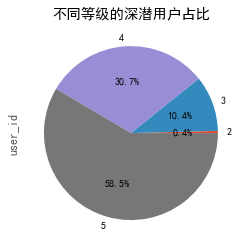

In [61]:
user_lv_count = user_table_high.groupby(by='user_lv_cd')['user_id'].count()

# plt.figure(figsize=(16,8),dpi=80)

user_lv_count.plot(kind='pie',autopct="%1.1f%%",title='不同等级的深潜用户占比')

plt.show()

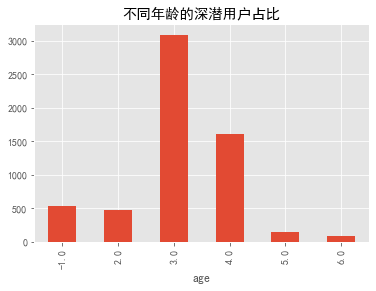

In [63]:
user_age_count = user_table_high.groupby(by='age')['user_id'].count()

user_age_count.plot(kind='bar',title='不同年龄的深潜用户占比')

plt.show()

In [ ]:
buy_num_groups = pd.cut(user_table_high['buy_num'], bins=[0,10,20,30,40,50])

# 获取每组的个数
group_count = user_table_high.groupby(buy_num_groups).count()

# 添加占比
group_count['rate'] = ['%.3f%%' % (value/user_table_high.count()['user_id']*100) for value in group_count['user_id'].values.tolist()]
group_count


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


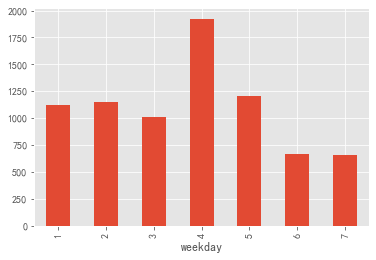

In [68]:
df_buy_high = ac_order_4[ac_order_4['user_id'].isin(high_dive.index.tolist())]

df_buy_high['time'] = df_buy_high['time'].astype('datetime64')

df_buy_high['weekday'] = df_buy_high['time'].apply(lambda x: x.weekday() + 1)

df_buy_high_count = df_buy_high.groupby(by='weekday')['user_id'].count()

df_buy_high_count.plot(kind='bar')

plt.show()